In [1]:
import cftime
import numpy as np
from dateutil.relativedelta import relativedelta
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import netCDF4
import glob
from pathlib import Path
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
import functions_py
import os
import cdo

In [2]:
case_dir = Path.home() / "Data/ATKINS/pycpt" / "test_DJF_S_Africa"

In [3]:
forecast_folders = ['Dec-Feb_20238_S_Africa', 'Nov-Jan_20238_S_Africa', 'Oct-Dec_20238_S_Africa']

data_dir = '/home/tnkemelang/Data/ATKINS/pycpt/'+ forecast_folders[2]+'/5W-60E_to_-40S-10N/data/'
processed_dir = data_dir + 'processed'
if os.path.exists(processed_dir):
    print('Path already exixts')
else:
    os.mkdir(processed_dir)
#processed_dir = data_dir + 'processed'
#os.mkdir('./plots')

Path already exixts


In [4]:
all_files = glob.glob(data_dir + "*.PRCP.nc")
n_datasets = len(all_files)

In [5]:
models_hist = list(filter(lambda a: 'UCSB.PRCP' not in a, all_files))
chirps_file = list(filter(lambda a: 'UCSB.PRCP' in a, all_files))[0]

In [6]:
model = models_hist[0]
model_name = model.split('/')[-1].split('.')[0]

In [7]:
season = data_dir.split('/')[-4].split('_')[0]

In [8]:
## Preprocessing data

In [9]:
year1 = str(1991)
year2 = str(2022)

i=1

var = 'pr'
chirps_name = 'CHIRPS'
chirps_data = xr.open_dataset(chirps_file)
#ds = chirps_data.chunk('auto')
ds = chirps_data
#print("Checking spatial and time coordinates naming and converting if needed", '\n')

if "T" in ds.coords.keys():
    #print("found T - renaming to time")
    ds=ds.rename({"T":"time"})
if "X" in ds.coords.keys():
    #print("found X - renaming to longitude")
    ds=ds.rename({"X":"longitude"})
if "Y" in ds.coords.keys():
    #print("found Y - renaming to longitude")
    ds=ds.rename({"Y":"latitude"})
if "lon" in ds.coords.keys():
    #print("found lon - renaming to longitude")
    ds=ds.rename({"lon":"longitude"})
if "lat" in ds.coords.keys():
    #print("found lat - renaming to latitude")
    ds=ds.rename({"lat":"latitude"})

ds = xr.decode_cf(ds)
ds=ds.convert_calendar("standard", align_on="date", use_cftime=True)

ds = ds.rename({'prcp':'pr'})

ds_file = processed_dir + '/'+ chirps_name + '_pr.nc'
ds.to_netcdf(ds_file)  

file_metadata = pd.DataFrame()

for ifile in models_hist: 
    i=i+1
    var = 'pr'
    model_name = ifile.split('/')[-1].split('.')[0]
    file_xr = xr.open_dataset(ifile)
    #ds = file_xr.chunk('auto')
    ds = file_xr
   
    #print("Checking spatial and time coordinates naming and converting if needed", '\n')

    if "T" in ds.coords.keys():
        #print("found T - renaming to time")
        ds=ds.rename({"T":"time"})
    if "X" in ds.coords.keys():
        #print("found X - renaming to longitude")
        ds=ds.rename({"X":"longitude"})
    if "Y" in ds.coords.keys():
        #print("found Y - renaming to longitude")
        ds=ds.rename({"Y":"latitude"})
    if "lon" in ds.coords.keys():
        #print("found lon - renaming to longitude")
        ds=ds.rename({"lon":"longitude"})
    if "lat" in ds.coords.keys():
        #print("found lat - renaming to latitude")
        ds=ds.rename({"lat":"latitude"})

    ds = xr.decode_cf(ds)
    ds=ds.convert_calendar("standard", align_on="date", use_cftime=True)
    print(list(ds.keys()))
    
    ds = ds.rename({'prcp':'pr'})
    
    ds_file_model = processed_dir + '/'+ model_name + '_pr.nc'
    ds_file_chrips_to_model = processed_dir + '/'+ model_name + '_pr_regridded.nc'
    ds.to_netcdf(ds_file_model)


    lons = ds.variables['longitude'][:]
    lats = ds.variables['latitude'][:]

    file_metadata_1 = pd.DataFrame([model_name, str(ds.time.min().dt.year.values), str(ds.time.max().dt.year.values), str((lons[1] - lons[0]).values), str((lats[1] - lats[0]).values)]).T
    
    file_metadata = pd.concat([file_metadata, file_metadata_1], axis=0)

    ####################################################################

    import subprocess, sys

    ds_file_chrips_to_model = processed_dir + '/'+ model_name + '_pr_regridded.nc'
    get_model_grid = 'cdo griddes ' + ds_file_model + ' > ds_file_model'
    regrid_chirps = 'cdo remapbil,ds_file_model ' + ds_file + ' ' + ds_file_chrips_to_model
    add_lonlatcoords_model = 'ncatted -O -a units,longitude,c,c,"degrees_east" -a units,latitude,c,c,"degrees_north" ' + ds_file_model
    add_lonlatcoords_chirps = 'ncatted -O -a units,longitude,c,c,"degrees_east" -a units,latitude,c,c,"degrees_north" ' + ds_file
    change_grid_type = 'sed -i "s/generic/lonlat/g" ds_file_model' 
    
    subprocess.run(add_lonlatcoords_model, shell = True, executable="/bin/bash")
    subprocess.run(add_lonlatcoords_chirps, shell = True, executable="/bin/bash")
    subprocess.run(get_model_grid, shell = True, executable="/bin/bash")
    subprocess.run(change_grid_type, shell = True, executable="/bin/bash")
    subprocess.run(regrid_chirps, shell = True, executable="/bin/bash")

    ####################################################################


['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (55x50) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.02s 257MB].
['prcp']


Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Warning (cdfInqContents): Coordinates variable S can't be assigned!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Wa

cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (55x50) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']


Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Warning (cdfInqContents): Coordinates variable S can't be assigned!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Wa

cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']


Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Warning (cdfInqContents): Coordinates variable S can't be assigned!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Wa

cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].
['prcp']


Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Warning (cdfInqContents): Coordinates variable S can't be assigned!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (cdfInqContents): Coordinates variable Tf can't be assigned!
Warning (cdfInqContents): Coordinates variable Ti can't be assigned!
Warning (find_time_vars): Found more than one time variable, skipped variable Ti!
Warning (find_time_vars): Found more than one time variable, skipped variable Tf!
Warning (find_time_vars): Found more than one time variable, skipped variable S!
Wa

cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (56x51) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.02s 257MB].
['prcp']
cdo    remapbil: Bilinear weights from lonlat (220x200) to lonlat (55x50) grid, with source mask (20120)
cdo    remapbil: Processed 1320000 values from 1 variable over 30 timesteps [0.01s 257MB].


climatology climatology


/tmp/ipykernel_65181/4099638435.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


climatology bias


/tmp/ipykernel_65181/4099638435.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


mk_trend mk_trend


/tmp/ipykernel_65181/4099638435.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


climatology temporal_correlation


/tmp/ipykernel_65181/4099638435.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


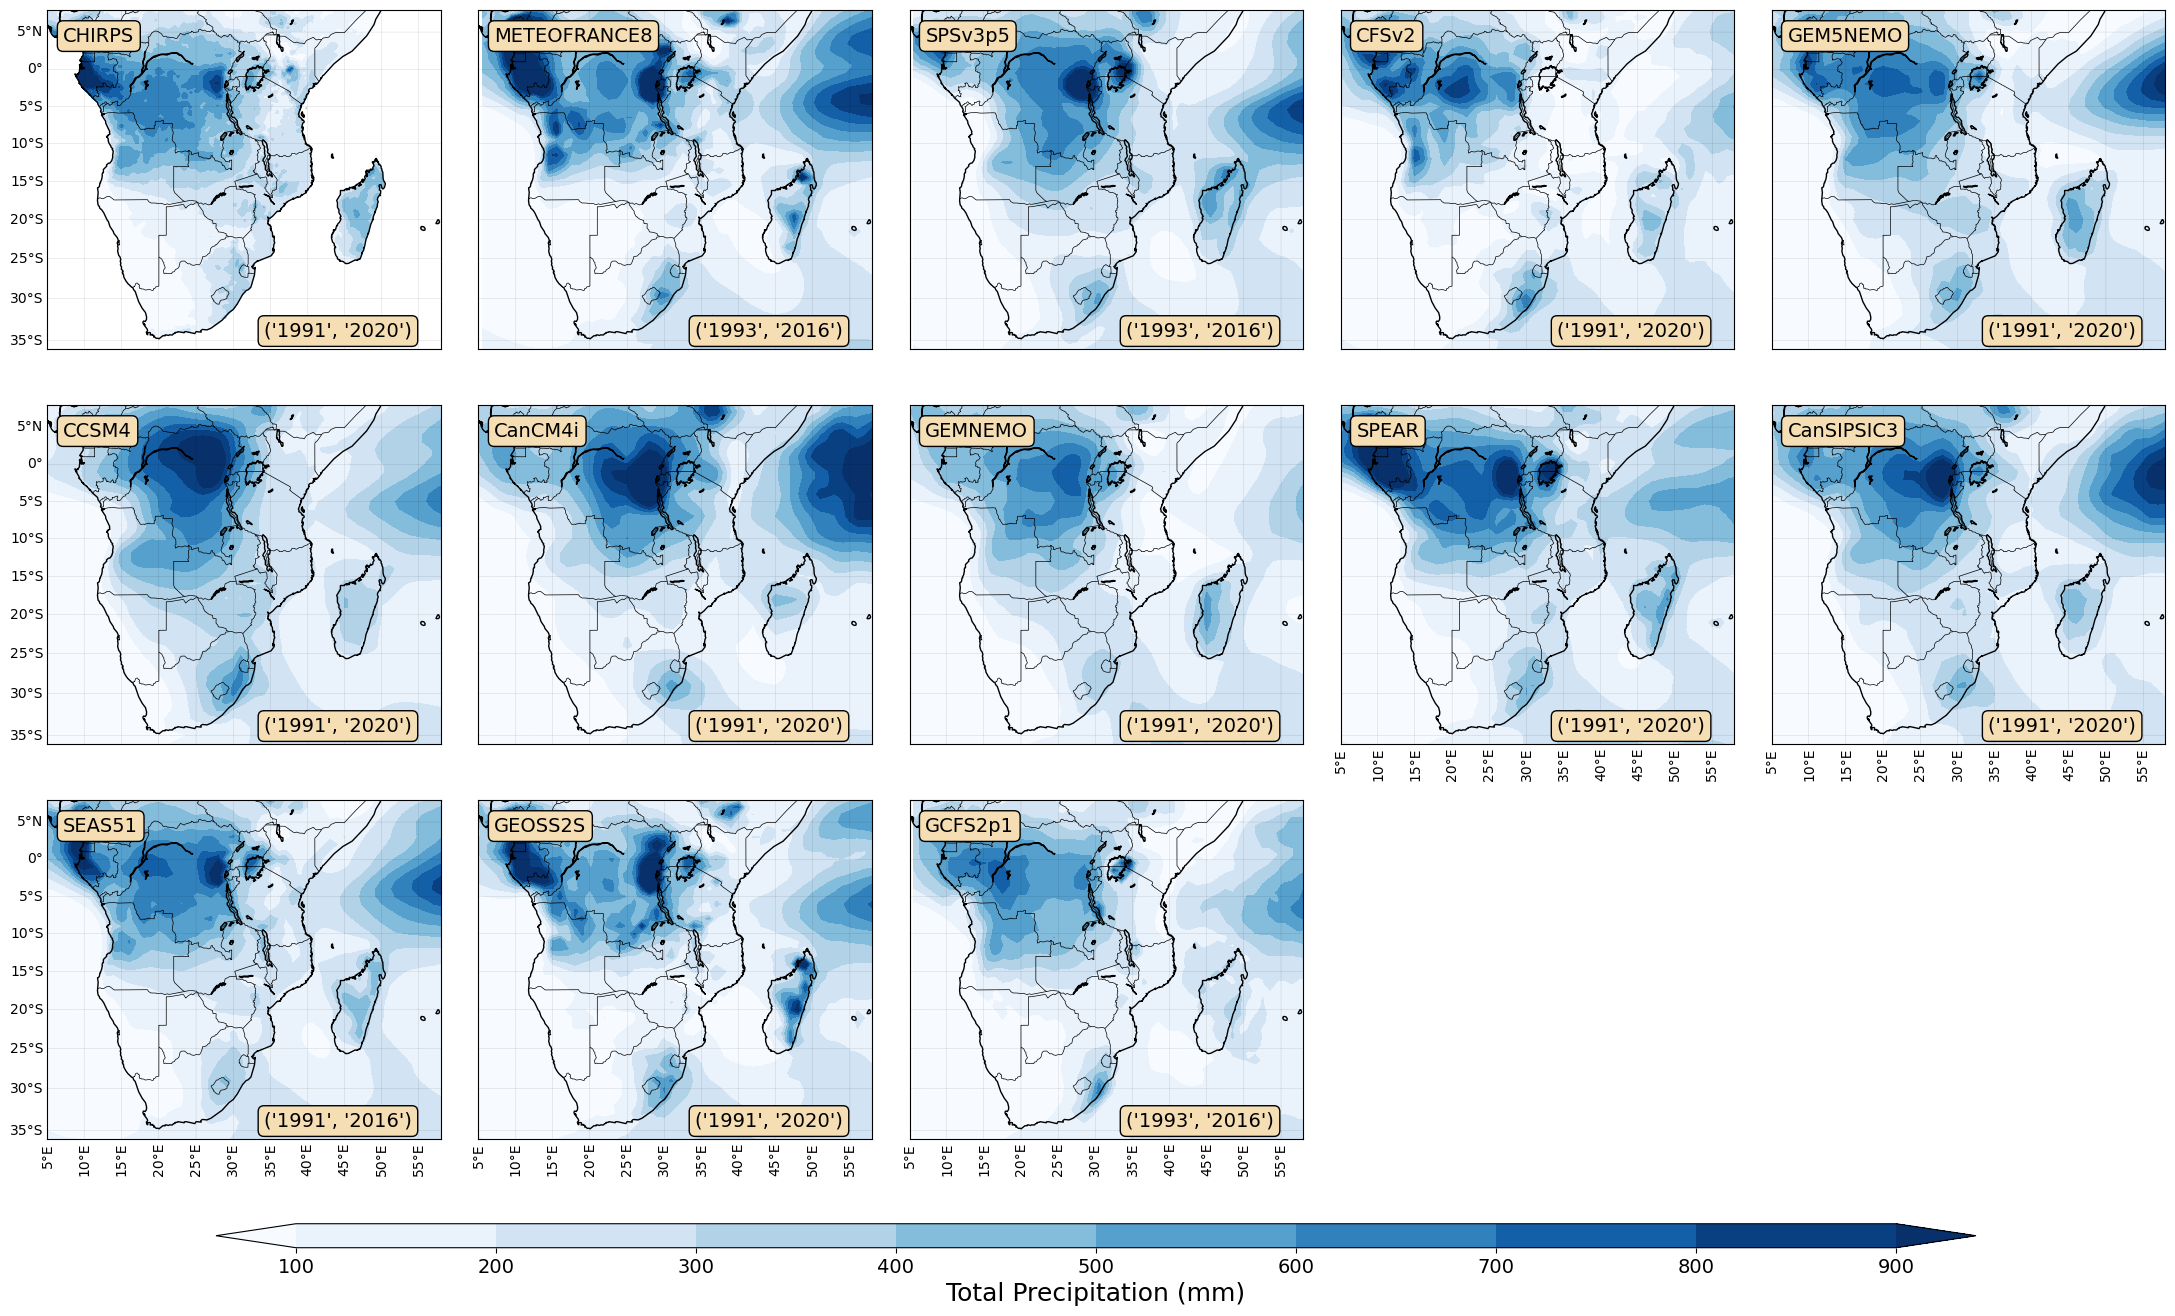

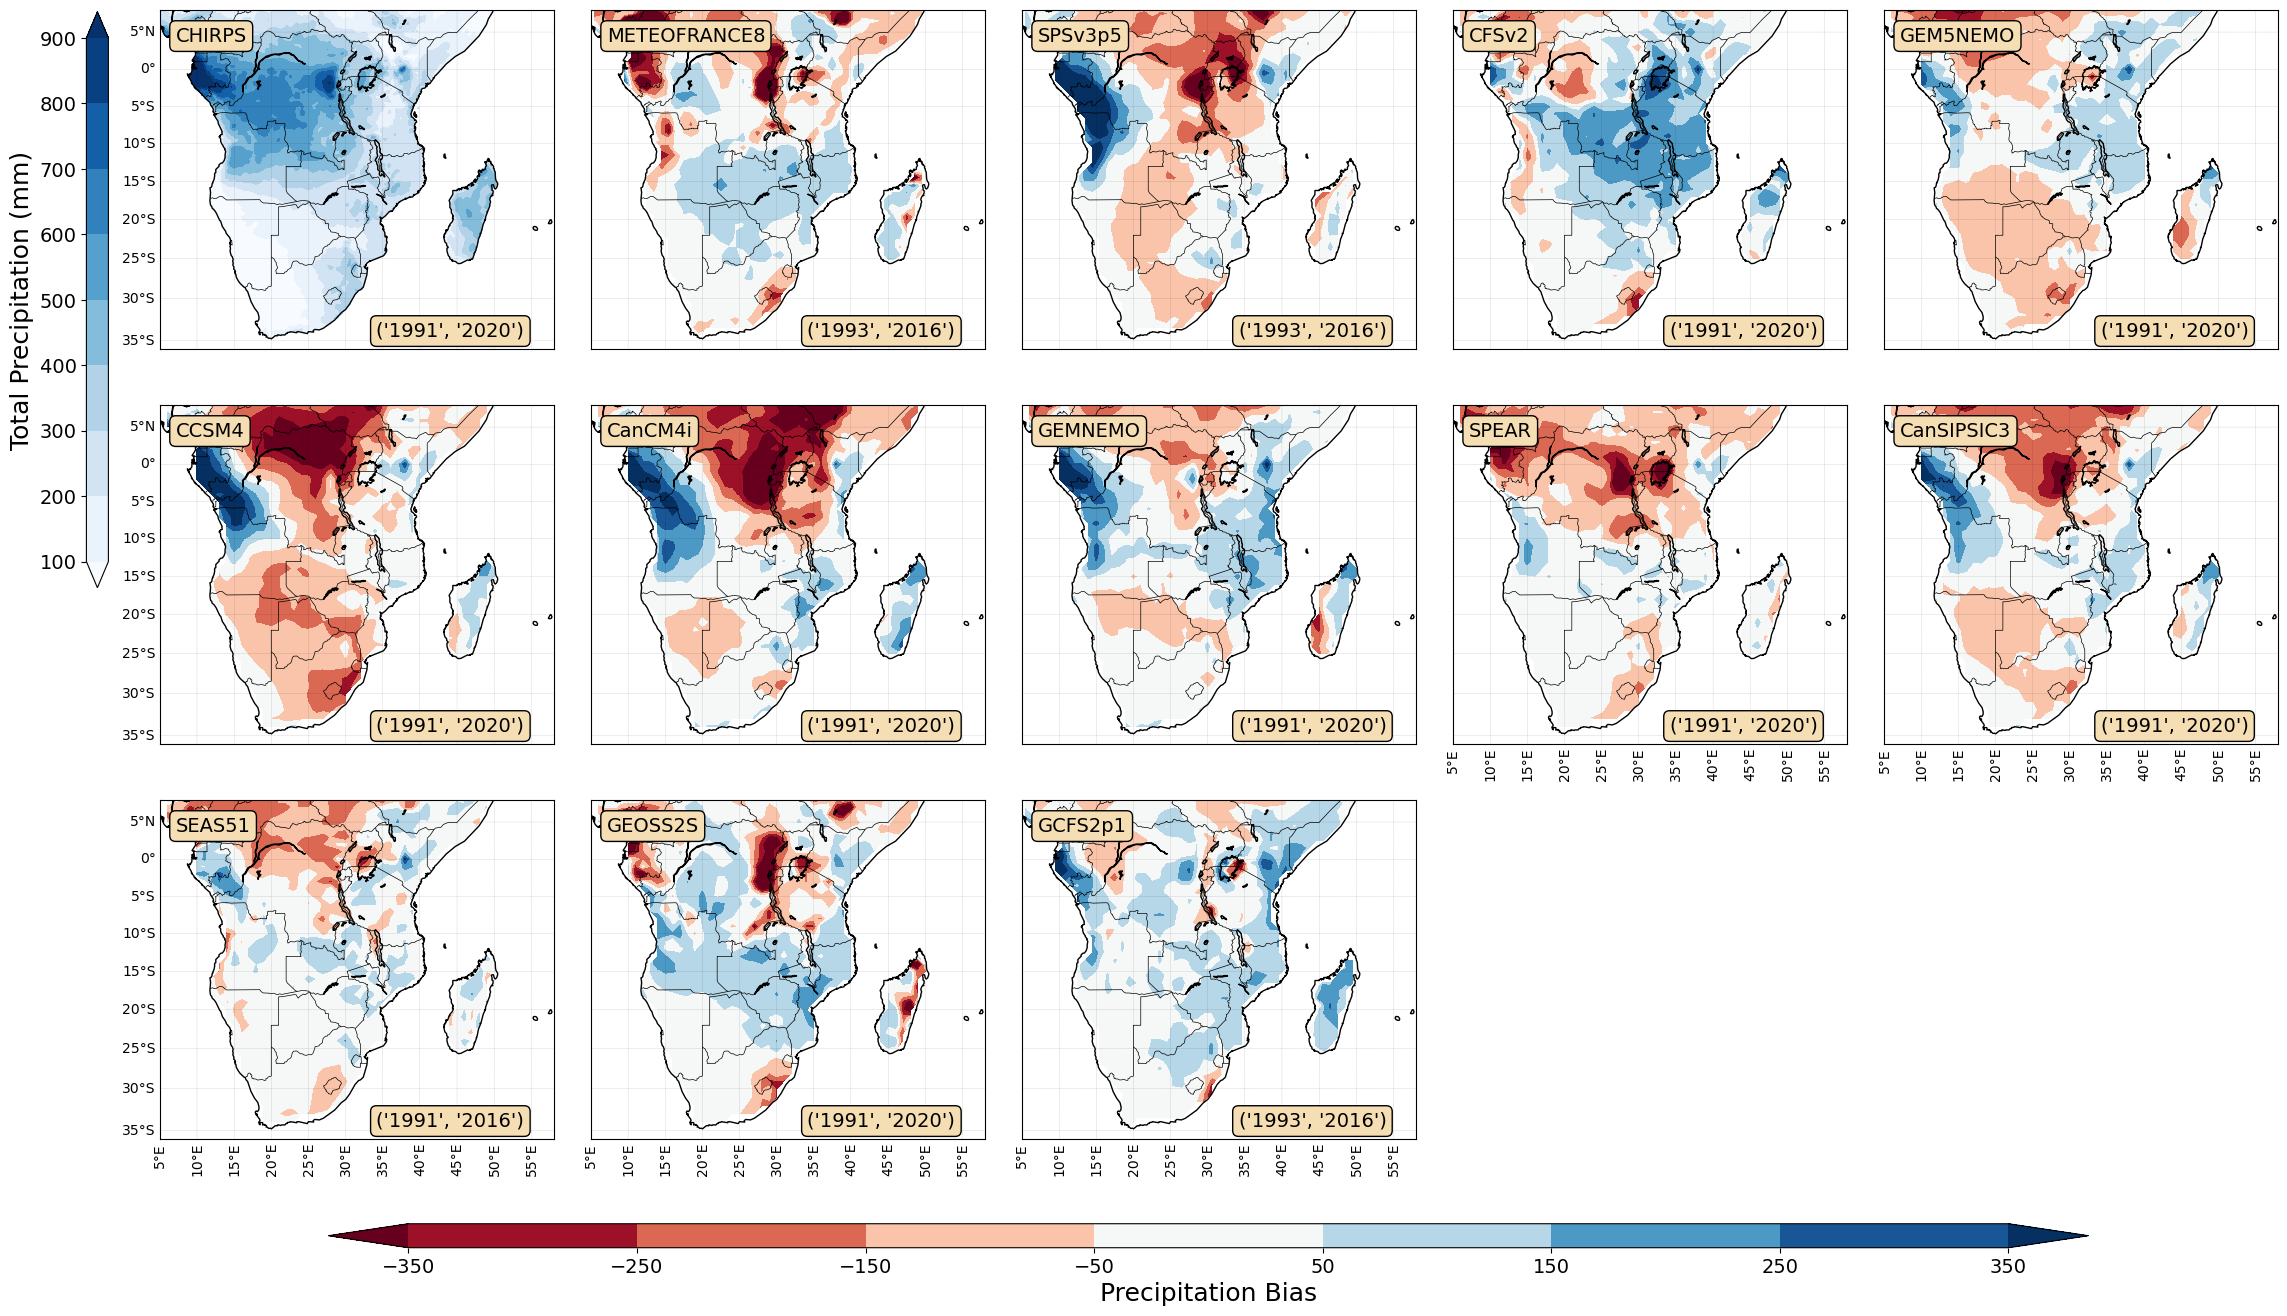

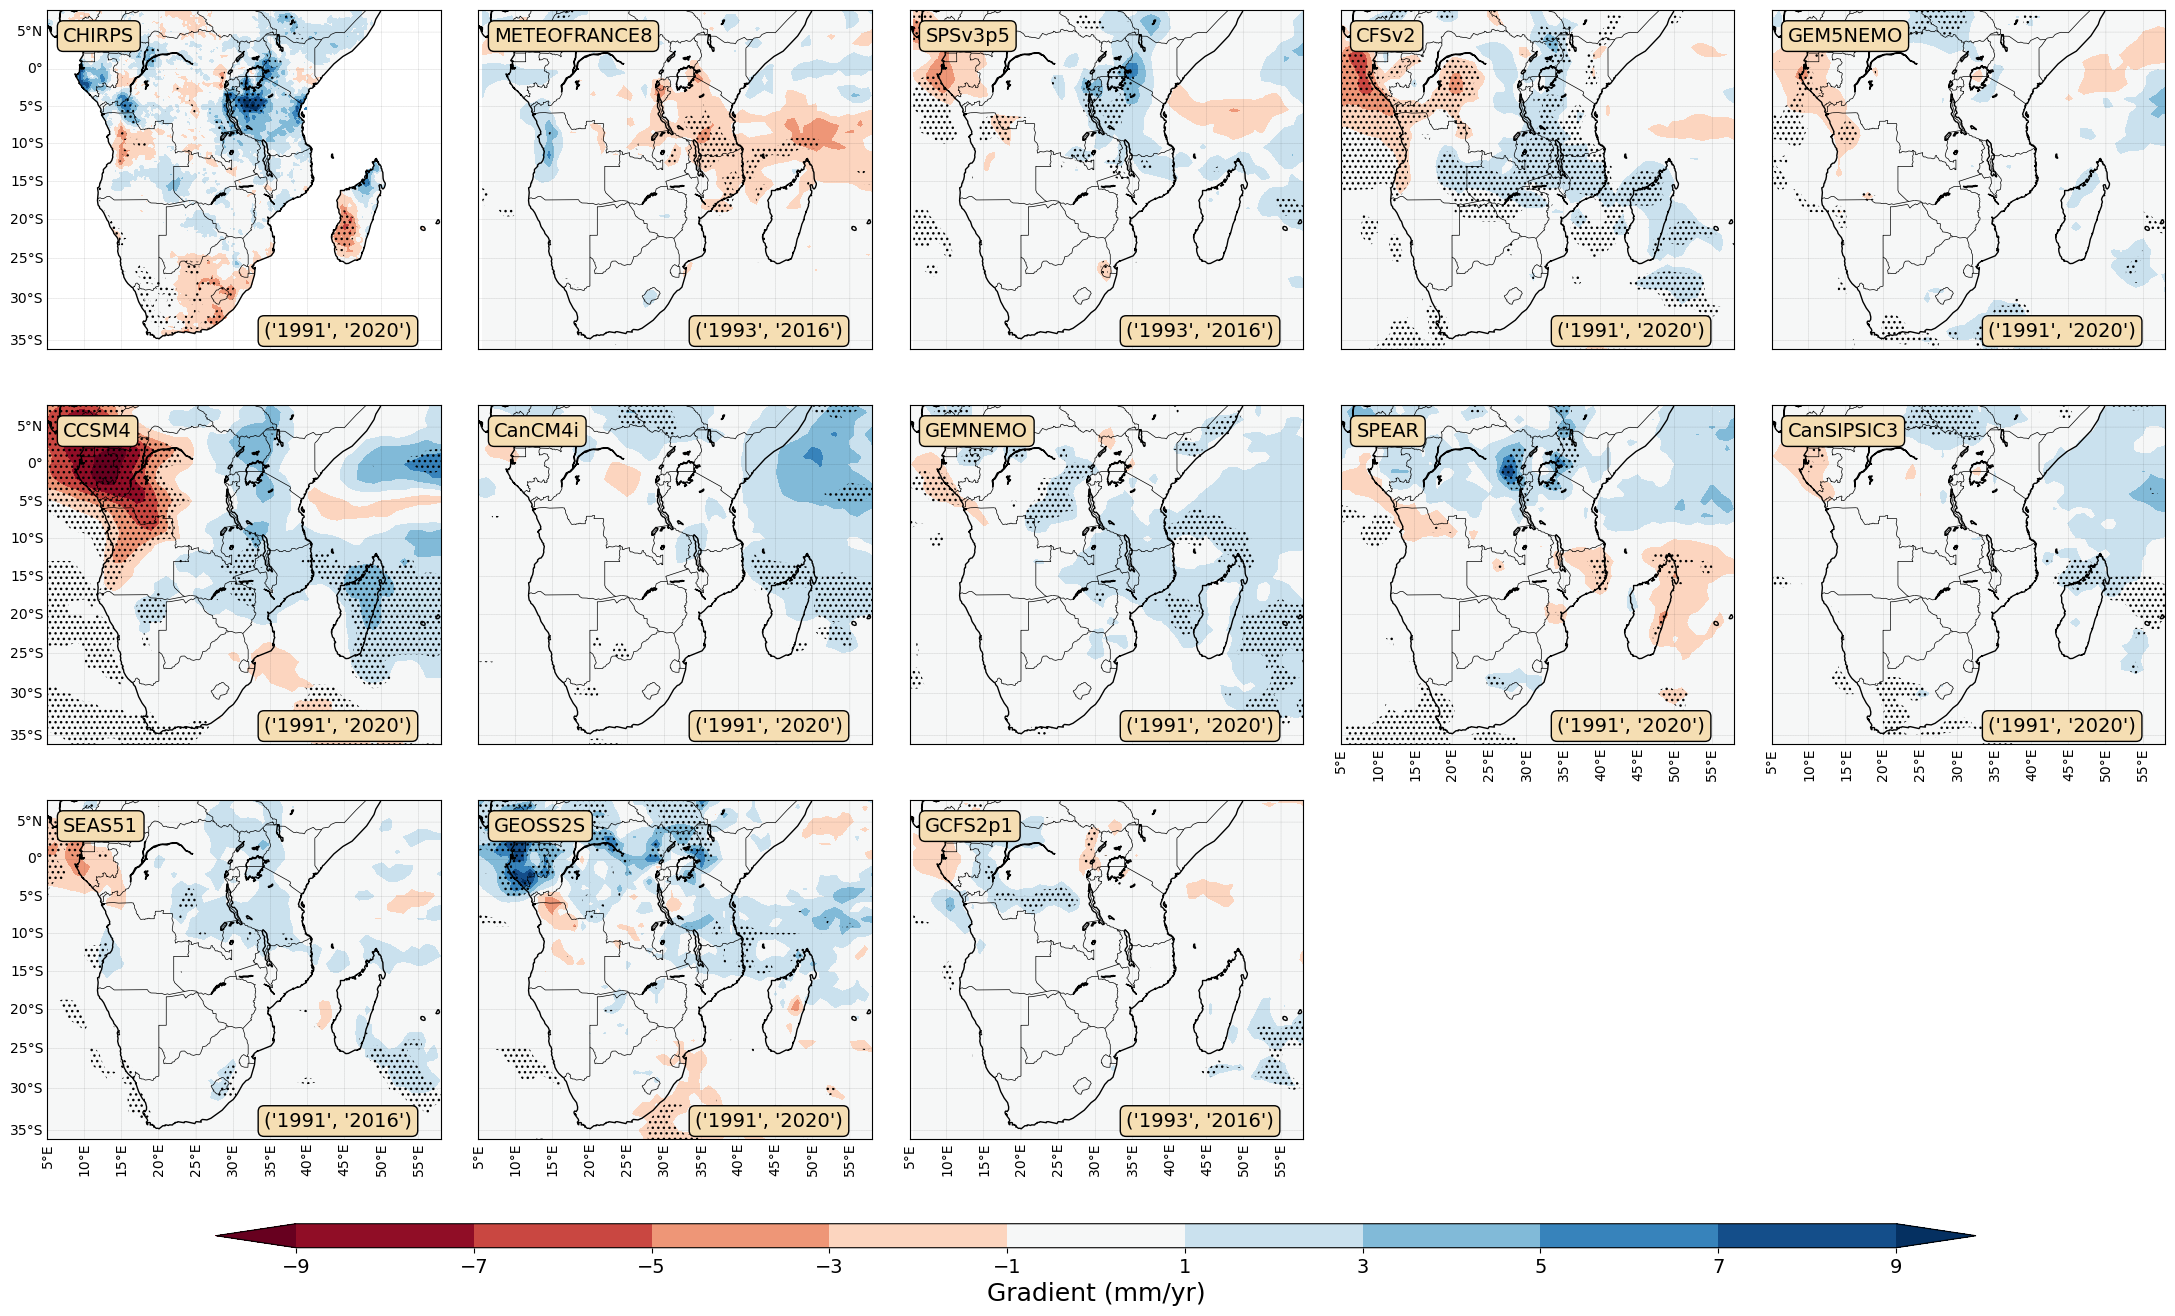

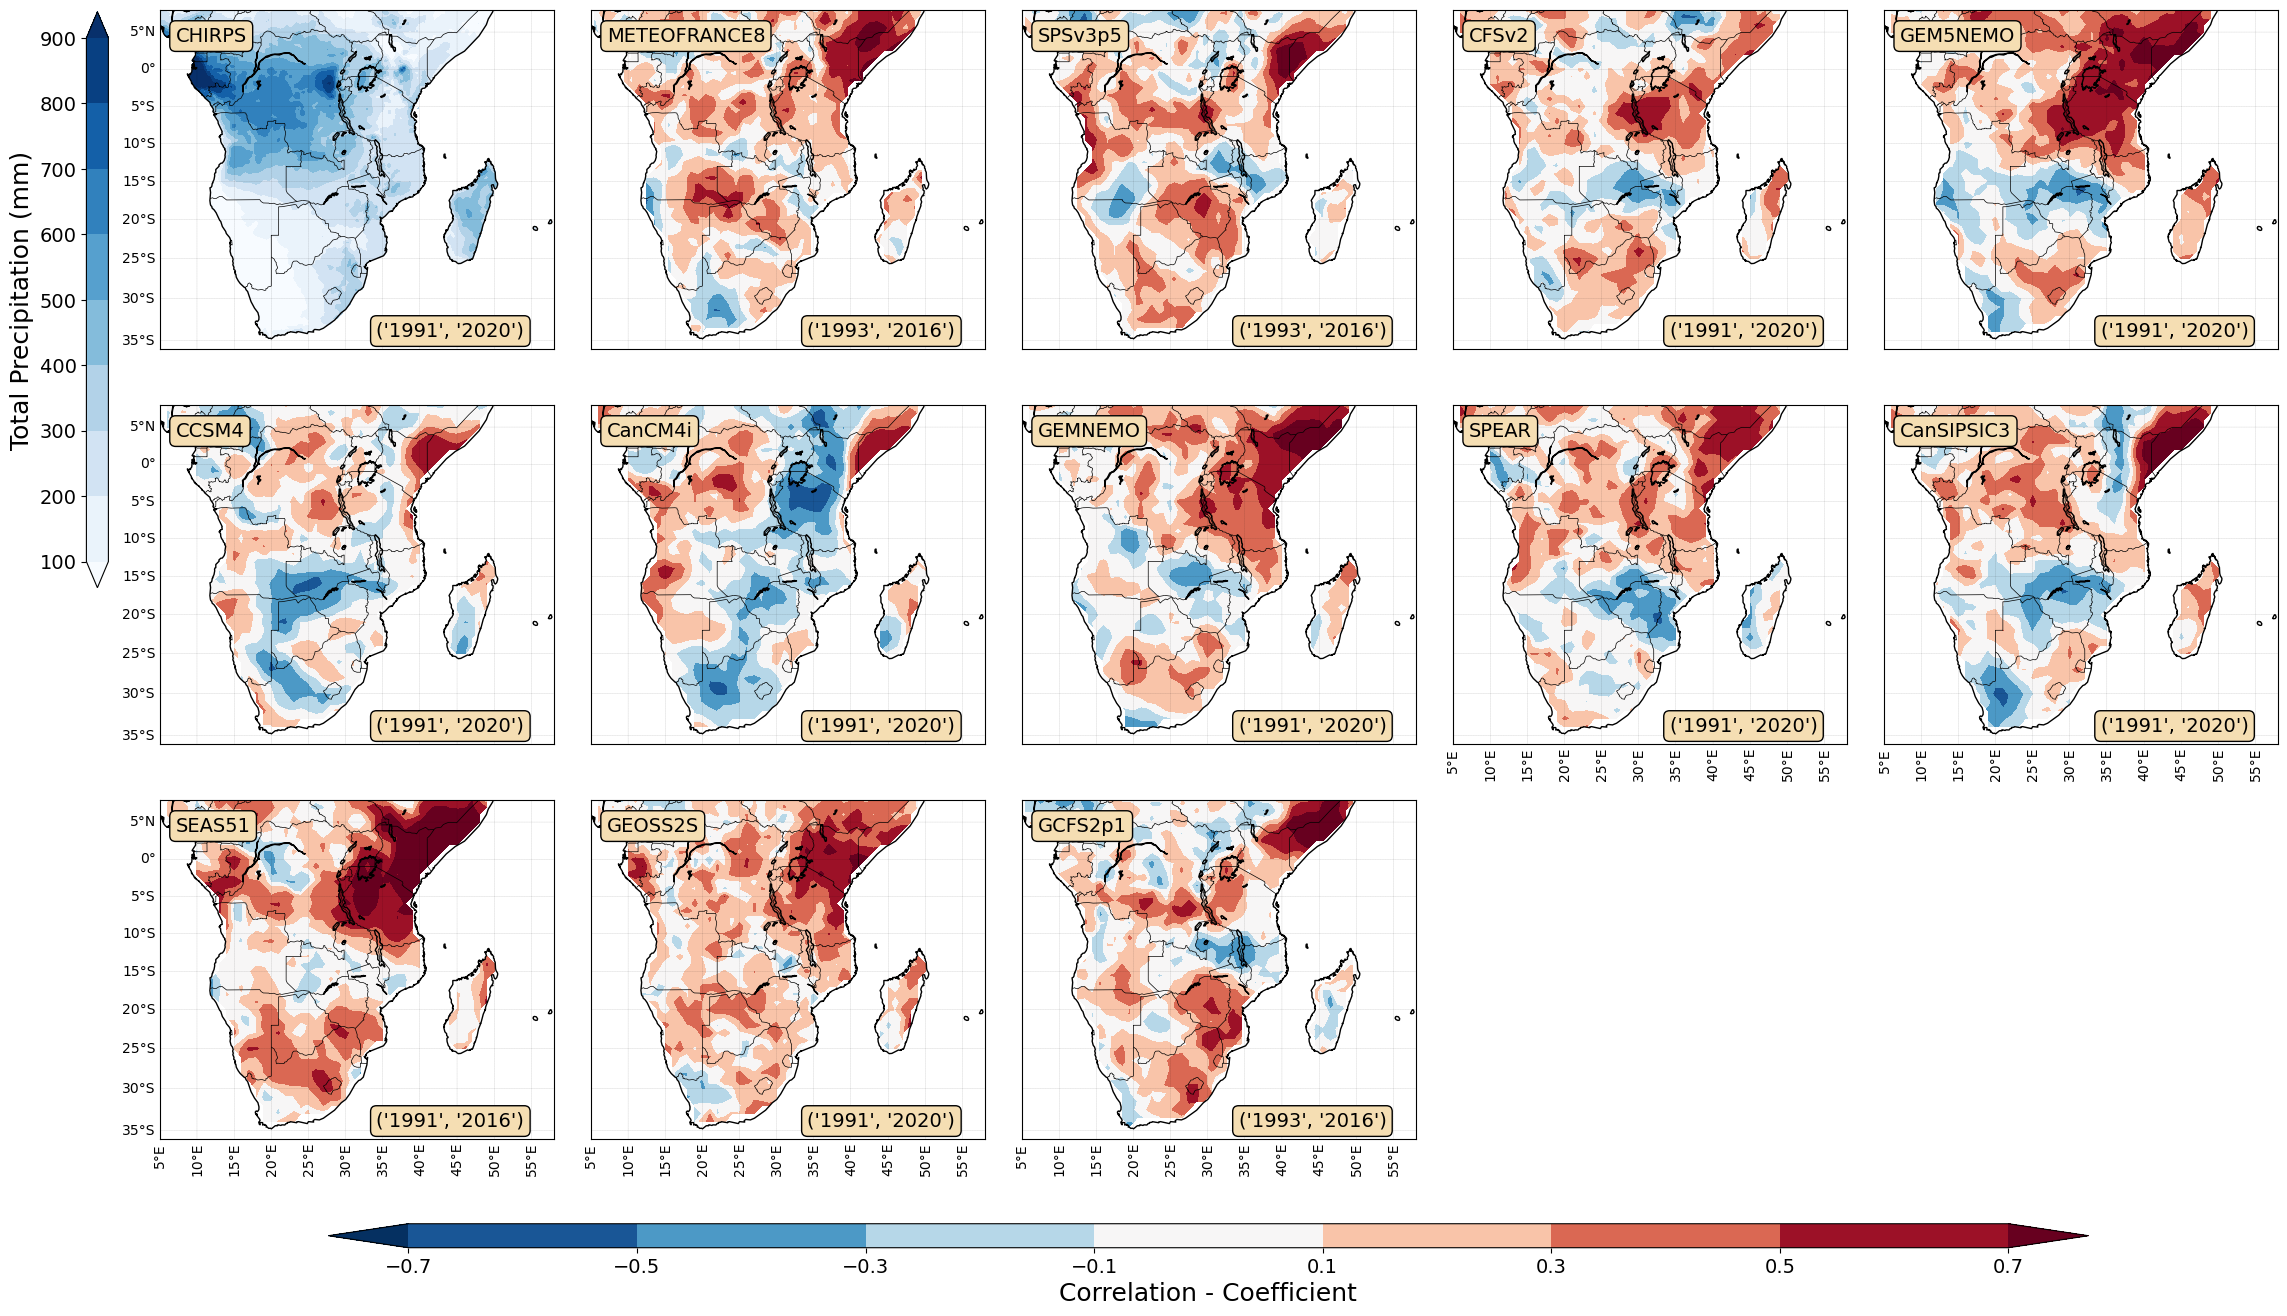

In [10]:
#fig = plt.figure(figsize=(22,18))
evaluation_metrices = ['climatology', 'bias', 'mk_trend', 'temporal_correlation']

for evaluation_metric in evaluation_metrices:
    
    #evaluation_metric = evaluation_metrices[0]
    
    fig_format = functions_py.fig_format(n_datasets)
    fig = fig_format[0]
    fig_array = fig_format[1]
    label_parallels = fig_format[2]
    label_meridians = fig_format[3]
    #fig, fig_array, label_parallels, label_meridians
    
    start_year = str(1991)
    end_year = str(2022)
    
    i=1
    
    ax = fig.add_subplot(fig_array[0], fig_array[1], i)
    
    var = 'pr'
    chirps_name = 'CHIRPS'
    chirps_data = xr.open_dataset(chirps_file)
    #ds = chirps_data.chunk('auto')
    ds = chirps_data
    #print("Checking spatial and time coordinates naming and converting if needed", '\n')
    
    if "T" in ds.coords.keys():
        #print("found T - renaming to time")
        ds=ds.rename({"T":"time"})
    if "X" in ds.coords.keys():
        #print("found X - renaming to longitude")
        ds=ds.rename({"X":"longitude"})
    if "Y" in ds.coords.keys():
        #print("found Y - renaming to longitude")
        ds=ds.rename({"Y":"latitude"})
    if "lon" in ds.coords.keys():
        #print("found lon - renaming to longitude")
        ds=ds.rename({"lon":"longitude"})
    if "lat" in ds.coords.keys():
        #print("found lat - renaming to latitude")
        ds=ds.rename({"lat":"latitude"})
    
    ds = xr.decode_cf(ds)
    ds=ds.convert_calendar("standard", align_on="date", use_cftime=True)
    
    ds = ds.rename({'prcp':'pr'})
    
    if evaluation_metric in ['bias' , 'climatology', 'nrmse', 'temporal_correlation' ]:
        evaluation_metric_ref = 'climatology'
    if evaluation_metric in [ 'mk_trend', 'climatology' ]:
        evaluation_metric_ref = evaluation_metric

    print(evaluation_metric_ref, evaluation_metric)
    output = functions_py.plot_functions(evaluation_metric=evaluation_metric_ref, var=var, reference_dataset=ds, 
                                         target_dataset=ds, start_year=start_year, end_year=end_year)
    
    lons = ds.variables['longitude'][:]
    lats = ds.variables['latitude'][:]
    
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    
    clim_var_ref = output[0]
    levs = output[3]
    
    #pl1 = map.contourf(x2d,y2d,clim_var_ref[:,:],levs,extend='both',cmap=output[2])
    
    if evaluation_metric == 'mk_trend':
        hatches = ['...', None,None,None,None,None,None,None, None,None, None, None,None,None,None,None,None,None,None,None]
        levs_pval = np.arange(0,1,0.05)
        to_plot_1 = output[0][0]
        to_plot_2 = output[0][1]
        pl1 = map.contourf(x2d,y2d,to_plot_1[:,:],levs,extend='both',cmap=output[2])
        ab2 = map.contourf(x2d,y2d,to_plot_2[:,:],levs_pval,hatches=hatches, colors = 'none')
    else:
        to_plot =  output[0]
        pl1 = map.contourf(x2d,y2d,to_plot[:,:],levs,extend='both',cmap=output[2])
    
    map.drawcoastlines()
    map.drawcountries()        
    
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=label_parallels[i-1], fontsize=10,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
        labels=label_meridians[i-1], fontsize=10,linewidth=0.1)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.04, 0.95, chirps_name, fontsize=14, verticalalignment='top', transform=ax.transAxes, bbox=props)
    ax.text(0.55, 0.08, (str(output[4]), str(output[5])),
            fontsize=14, verticalalignment='top', transform=ax.transAxes, bbox=props  )
    
    file_metadata = pd.DataFrame()
    
    for ifile in models_hist: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(fig_array[0], fig_array[1], i)
        model_name = ifile.split('/')[-1].split('.')[0]
        
        ds_file_chrips_to_model = processed_dir + '/'+ model_name + '_pr_regridded.nc'
        ds_file_model = processed_dir + '/'+ model_name + '_pr.nc'
        
        ds = xr.open_dataset(ds_file_chrips_to_model)
        ds_model = xr.open_dataset(ds_file_model)
        
        mon_init = str(ds_model[var].S[0].dt.month.values)
        lead_months = ds_model[var].attrs['L'].split(' ')[0]
        
        
        output_1 = functions_py.plot_functions(evaluation_metric=evaluation_metric, var=var, reference_dataset=ds, 
                                         target_dataset=ds_model, start_year=start_year, end_year=end_year)
        
        lons = ds.variables['longitude'][:]
        lats = ds.variables['latitude'][:]
    
        levs_1 = output_1[3]
        #print(levs_1)
        
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
    
        if evaluation_metric == 'mk_trend':
            hatches = ['...', None,None,None,None,None,None,None, None,None, None, None,None,None,None,None,None,None,None,None]
            levs_pval = np.arange(0,1,0.05)
            to_plot_1 = output_1[0][0]
            to_plot_2 = output_1[0][1]
            pl2 = map.contourf(x2d,y2d,to_plot_1[:,:],levs_1,extend='both',cmap=output_1[2])
            ab2 = map.contourf(x2d,y2d,to_plot_2[:,:],levs_pval,hatches=hatches, colors = 'none')
        else:
            to_plot =  output_1[0]
            pl2 = map.contourf(x2d,y2d,to_plot[:,:],levs_1,extend='both',cmap=output_1[2])
        #print([min_val, max_val])
        
        map.drawcoastlines()
        map.drawcountries()        
    
        map.drawparallels(np.arange(-80., 81., 5), \
            labels=label_parallels[i-1], fontsize=10,linewidth=0.1)
        map.drawmeridians(np.arange(-180., 181., 5),\
            labels=label_meridians[i-1], fontsize=10,linewidth=0.1, rotation=90)
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.04, 0.95, model_name, fontsize=14, verticalalignment='top', transform=ax.transAxes, bbox=props)
        ax.text(0.55, 0.08, (str(output_1[4]), str(output_1[5])),
            fontsize=14, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    if evaluation_metric in ['bias', 'nrmse', 'temporal_correlation' ]:
        cax2 = fig.add_axes([-0.01, 0.5, 0.01, 0.48])   
        bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
        bar2.set_label('Total Precipitation (mm)',size=18)
        bar2.ax.tick_params(labelsize=14) 
        #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')
    
    cax = fig.add_axes([0.1, -0.05, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.ax.tick_params(labelsize=14) 
    bar.set_label(output_1[1],size=18)
    plt.tight_layout()
    output = []
    output_1 = []
    
    plt.savefig('./plots/'+var+'_'+evaluation_metric+'_'+season+'_initmon-'+mon_init+'_nleadmon-'+lead_months+'.png', bbox_inches='tight',dpi=300)

In [11]:
ds_model[var].attrs['L'].split(' ')[0]

'3.0'

In [12]:
str(ds_model[var].[0].dt.month.values)
date_init = str(ds_model[var].S[0].dt.month.values)

SyntaxError: invalid syntax (954490628.py, line 1)

In [ ]:
file_metadata.columns = ['Model', 'Start_year', 'End_year', 'Longitude_res', 'Latitude_res']
file_metadata.to_csv('Available_models_and_hindcasts.csv')

In [ ]:
from cdo import Cdo
cdo = Cdo()

In [ ]:
import subprocess, sys

ds_file_chrips_to_model = processed + '/'+ model_name + '_pr_regridded.nc'
get_model_grid = 'cdo griddes ' + ds_file_model + ' > ds_file_model'
regrid_chirps = 'cdo remapbil,ds_file_model ' + ds_file + ' ' + ds_file_chrips_to_model
add_lonlatcoords_model = 'ncatted -O -a units,longitude,c,c,"degrees_east" -a units,latitude,c,c,"degrees_north" ' + ds_file_model
add_lonlatcoords_chirps = 'ncatted -O -a units,longitude,c,c,"degrees_east" -a units,latitude,c,c,"degrees_north" ' + ds_file
change_grid_type = 'sed -i "s/generic/lonlat/g" ds_file_model' 

subprocess.run(add_lonlatcoords_model, shell = True, executable="/bin/bash")
subprocess.run(add_lonlatcoords_chirps, shell = True, executable="/bin/bash")
subprocess.run(get_model_grid, shell = True, executable="/bin/bash")
subprocess.run(change_grid_type, shell = True, executable="/bin/bash")
subprocess.run(regrid_chirps, shell = True, executable="/bin/bash")



In [ ]:
ds.to_netcdf('/home/tnkemelang/Data/ATKINS/pycpt/test_DJF_S_Africa/10W-55E_to_-40S-5N/data/safe/'+model_name+'_S-Africa_'+
